In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#torch
import torch
from torch import nn

#torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix, BinaryAccuracy, MulticlassAccuracy
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report,accuracy_score

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold

import random
from PIL import Image
from pathlib import Path
from torchinfo import summary
import copy

from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MultipleLocator
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from collections import Counter

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data Exploration

In [3]:
#defining the file paths to load data
base_dir = os.getcwd()
image_dir = os.path.join(base_dir,'data','patch_images')
labels_main_dir = os.path.join(base_dir,"data","data_labels_mainData.csv")

In [4]:
#loading data_labels_mainData csv file for cell type classification
labels_main = pd.read_csv(labels_main_dir)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [6]:
#add image path column and confirm image exists
labels_main['imagePath'] = labels_main['ImageName'].apply(lambda x: os.path.join(image_dir,x))
labels_main['imageExists'] = labels_main['imagePath'].apply(lambda x: os.path.exists(x))
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath,imageExists
0,22405,1,22405.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
1,22406,1,22406.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
2,22407,1,22407.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
3,22408,1,22408.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
4,22409,1,22409.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True


In [7]:
#check image paths represented correctly
print("Sample images paths :")
print(labels_main.loc[0,'imagePath'])
print(labels_main.loc[4,'imagePath'])
#confirming all images exists
print("\nTotal number of images for cell type classification")
print(labels_main.imageExists.value_counts())

Sample images paths :
/Users/poornagunawardana/Desktop/Semester_4/CML/A2/image-classification-cml-g30/data/patch_images/22405.png
/Users/poornagunawardana/Desktop/Semester_4/CML/A2/image-classification-cml-g30/data/patch_images/22409.png

Total number of images for cell type classification
imageExists
True    9896
Name: count, dtype: int64


In [8]:
#Identifying unique values 
print(f"Unique values in 'cellTypeName' :{labels_main.cellTypeName.unique()}")
print(f"Unique values in 'cellType' \t:{labels_main.cellType.unique()}")
print(f"Unique values in 'isCancerous' \t:{labels_main.isCancerous.unique()}")

Unique values in 'cellTypeName' :['fibroblast' 'inflammatory' 'others' 'epithelial']
Unique values in 'cellType' 	:[0 1 3 2]
Unique values in 'isCancerous' 	:[0 1]


In [9]:
#cellType and cellTypeName connection
print(labels_main[['cellTypeName', 'cellType']].drop_duplicates().sort_values(by='cellType'))

     cellTypeName  cellType
0      fibroblast         0
11   inflammatory         1
449    epithelial         2
17         others         3


In [10]:
print(f"Unique values in 'patients' :{labels_main.patientID.unique()}")
print(f"No of patients :{labels_main.patientID.nunique()}")

Unique values in 'patients' :[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
No of patients :60


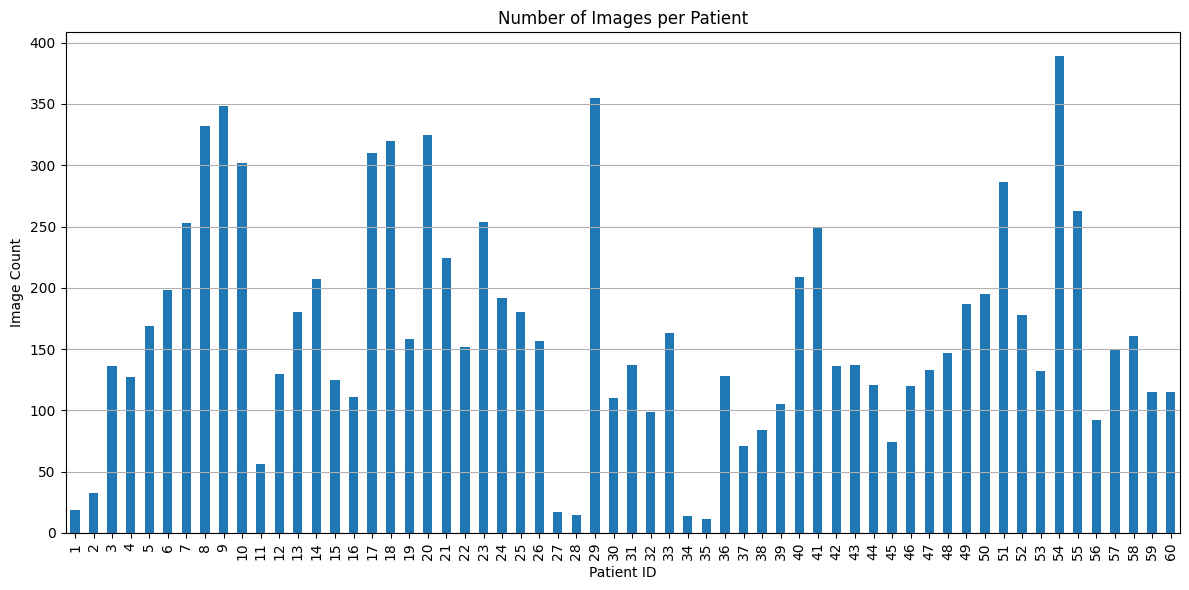

In [11]:
#plotting number of images per patient
patient_image_counts = pd.DataFrame(labels_main.patientID.value_counts().sort_index())

patient_image_counts.plot(kind='bar', legend=False, figsize=(12, 6))
plt.title('Number of Images per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Image Count')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

   cellTypeName  Raw_count  Raw_proportion
0    epithelial       4079            41.2
1  inflammatory       2543            25.7
2    fibroblast       1888            19.1
3        others       1386            14.0


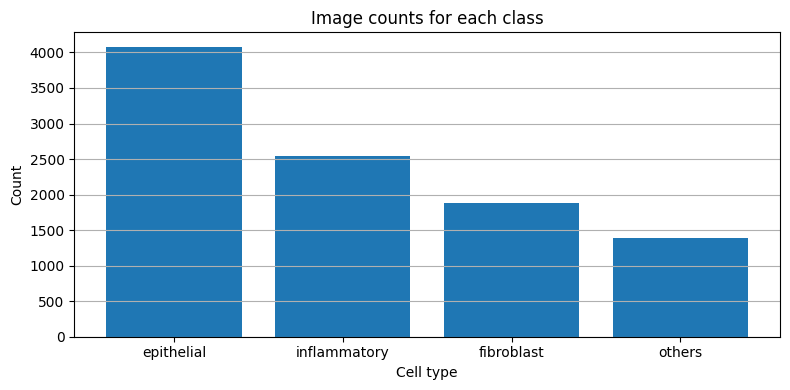

In [12]:
#no of images per class
cellType_counts = labels_main['cellTypeName'].value_counts().reset_index()
cellType_counts.columns = ['cellTypeName', 'Raw_count']
cellType_counts['Raw_proportion'] = round((cellType_counts['Raw_count'] / cellType_counts['Raw_count'].sum()) * 100, 1)

print(cellType_counts)

plt.figure(figsize=[8,4])
plt.bar(cellType_counts['cellTypeName'],cellType_counts['Raw_count'])
plt.title('Image counts for each class')
plt.xlabel('Cell type')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In [13]:
patient_cellType = labels_main.groupby(['patientID', 'cellTypeName']).size().unstack(fill_value=0)
patient_cellType.head()

cellTypeName,epithelial,fibroblast,inflammatory,others
patientID,,,,
1,0,11,6,2
2,0,8,18,7
3,0,53,73,10
4,0,39,81,7
5,35,25,103,6


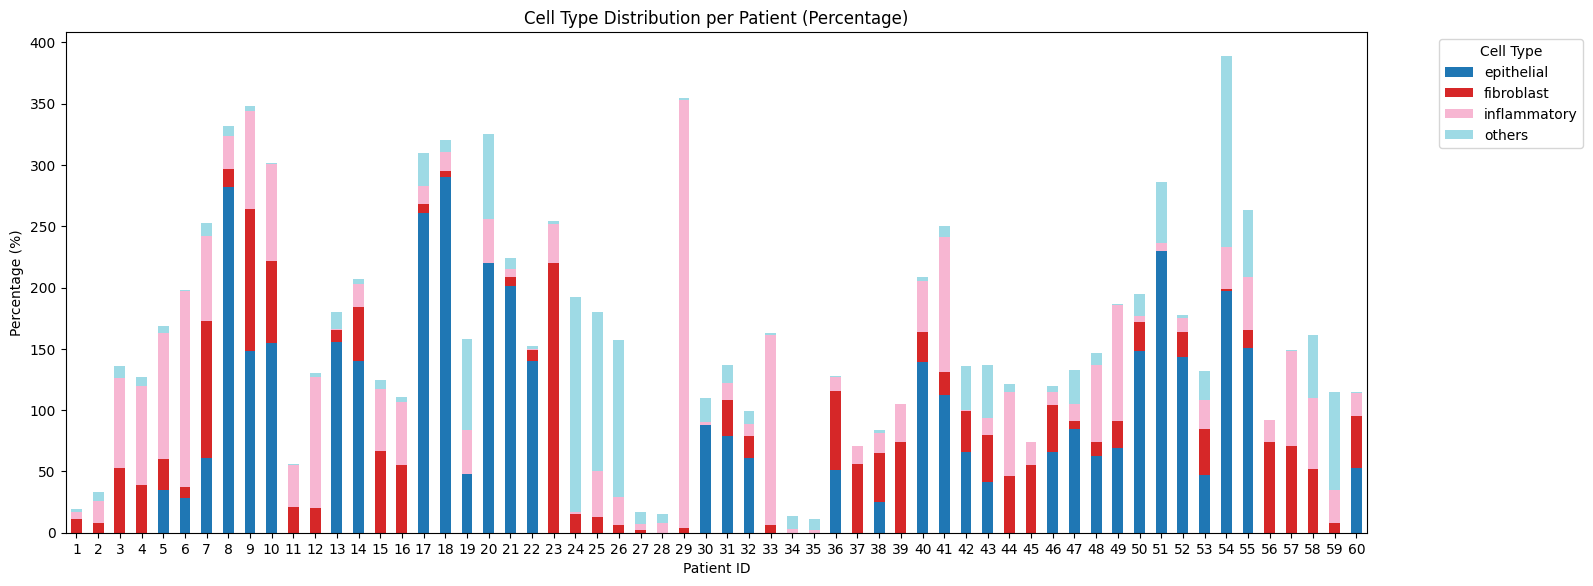

In [14]:
patient_cellType.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    colormap='tab20'
)

plt.ylabel("Percentage (%)")
plt.xlabel("Patient ID")
plt.title("Cell Type Distribution per Patient (Percentage)")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

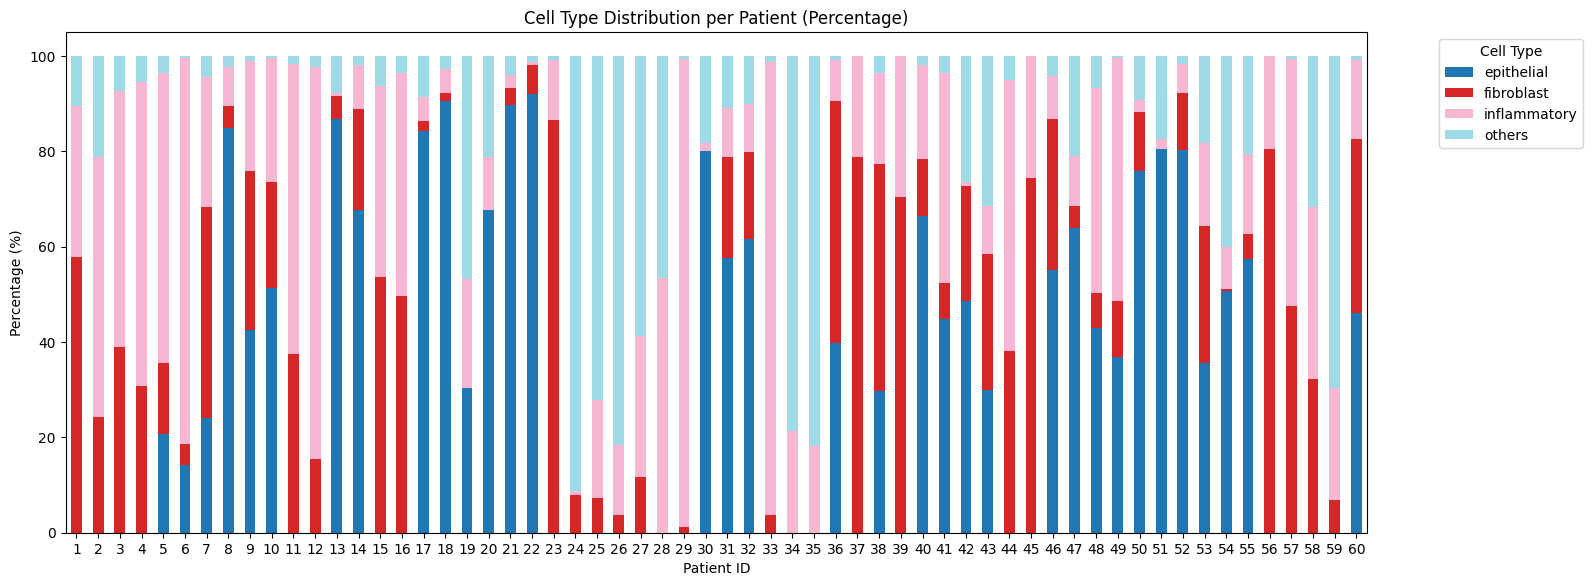

In [15]:
cell_percentages = patient_cellType.div(patient_cellType.sum(axis=1), axis=0) * 100

# Sort by patient ID for consistent plotting
cell_percentages = cell_percentages.sort_index()

# Plot
cell_percentages.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    colormap='tab20'
)

plt.ylabel("Percentage (%)")
plt.xlabel("Patient ID")
plt.title("Cell Type Distribution per Patient (Percentage)")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

### Data Splitting

In [16]:
y = labels_main["cellType"]      
groups = labels_main["patientID"]      

# first split for test data
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)  

train_val_idx, test_idx = next(sgkf.split(labels_main, y, groups))               # take the first fold as test
df_train_val = labels_main.iloc[train_val_idx].reset_index(drop=True)
df_test      = labels_main.iloc[test_idx]     .reset_index(drop=True)

# second split for val data
y_tv      = df_train_val["cellType"]
groups_tv = df_train_val["patientID"]

sgkf_val = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)   # 1/4 ≈ 25 % of train_val ⇒ 20 % overall
train_idx, val_idx = next(sgkf_val.split(df_train_val, y_tv, groups_tv))

df_train = df_train_val.iloc[train_idx].reset_index(drop=True)
df_val   = df_train_val.iloc[val_idx].reset_index(drop=True)

In [17]:
print(f"Number of images in Train set: {len(df_train)}")
print(f"Number of images in Validation set: {len(df_val)}")
print(f"Number of images in Test set: {len(df_test)}")

Number of images in Train set: 5944
Number of images in Validation set: 2071
Number of images in Test set: 1881


In [18]:
# Raw counts and proportions
cellType_counts = labels_main['cellTypeName'].value_counts().reset_index()
cellType_counts.columns = ['cellTypeName', 'Raw_count']

raw_proportions = labels_main['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
raw_proportions.columns = ['cellTypeName', 'Raw_proportion']
cellType_counts = cellType_counts.merge(raw_proportions, on='cellTypeName')

# Train counts and proportions
train_counts = df_train['cellTypeName'].value_counts().reset_index()
train_counts.columns = ['cellTypeName', 'Train_count']
train_proportions = df_train['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
train_proportions.columns = ['cellTypeName', 'Train_proportion']

cellType_counts = cellType_counts.merge(train_counts, on='cellTypeName')
cellType_counts = cellType_counts.merge(train_proportions, on='cellTypeName')

# Validation counts and proportions
val_counts = df_val['cellTypeName'].value_counts().reset_index()
val_counts.columns = ['cellTypeName', 'Val_count']
val_proportions = df_val['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
val_proportions.columns = ['cellTypeName', 'Val_proportion']

cellType_counts = cellType_counts.merge(val_counts, on='cellTypeName')
cellType_counts = cellType_counts.merge(val_proportions, on='cellTypeName')

# Test counts and proportions
test_counts = df_test['cellTypeName'].value_counts().reset_index()
test_counts.columns = ['cellTypeName', 'Test_count']
test_proportions = df_test['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
test_proportions.columns = ['cellTypeName', 'Test_proportion']

cellType_counts = cellType_counts.merge(test_counts, on='cellTypeName')
cellType_counts = cellType_counts.merge(test_proportions, on='cellTypeName')

# Reorder columns
cellType_counts = cellType_counts[[
    'cellTypeName', 'Raw_count', 'Train_count', 'Val_count', 'Test_count',
    'Raw_proportion', 'Train_proportion', 'Val_proportion', 'Test_proportion'
]]

# Display result
cellType_counts


,cellTypeName,Raw_count,Train_count,Val_count,Test_count,Raw_proportion,Train_proportion,Val_proportion,Test_proportion
0,epithelial,4079,2314,848,917,41.2,38.9,40.9,48.8
1,inflammatory,2543,1400,714,429,25.7,23.6,34.5,22.8
2,fibroblast,1888,1053,425,410,19.1,17.7,20.5,21.8
3,others,1386,1177,84,125,14.0,19.8,4.1,6.6


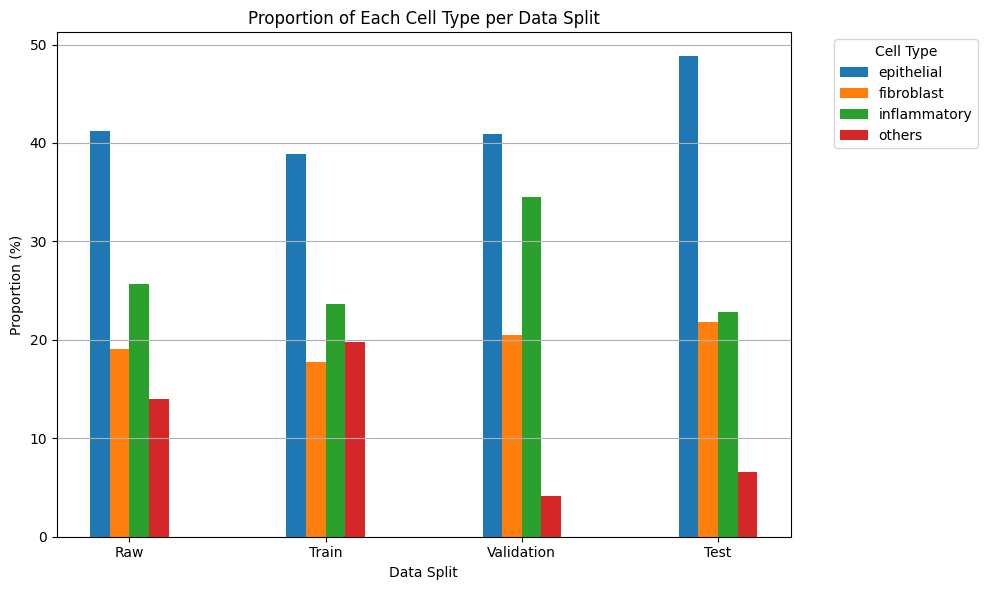

In [19]:
# Melt to long format
melted = cellType_counts.melt(
    id_vars='cellTypeName',
    value_vars=['Raw_proportion', 'Train_proportion', 'Val_proportion', 'Test_proportion'],
    var_name='Split',
    value_name='Proportion'
)

# Clean and order split labels
melted['Split'] = (
    melted['Split']
    .str.replace('_proportion', '', regex=False)
    .replace({'Val': 'Validation'})
)

# Define split order
split_order = ['Raw', 'Train', 'Validation', 'Test']
melted['Split'] = pd.Categorical(melted['Split'], categories=split_order, ordered=True)
melted = melted.sort_values('Split')

# Pivot for grouped bar plot
pivoted = melted.pivot(index='Split', columns='cellTypeName', values='Proportion')

# Plot settings
splits = pivoted.index.tolist()
cell_types = pivoted.columns.tolist()
x = np.arange(len(splits))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))

# Draw one bar per cell type per split
for i, cell_type in enumerate(cell_types):
    ax.bar(x + i * width, pivoted[cell_type], width, label=cell_type)

# Final touches
ax.set_xlabel('Data Split')
ax.set_ylabel('Proportion (%)')
ax.set_title('Proportion of Each Cell Type per Data Split')
ax.set_xticks(x + width * (len(cell_types) - 1) / 2)
ax.set_xticklabels(splits)
ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [20]:
# Get unique patient IDs per split
train_patients = set(df_train['patientID'].unique())
val_patients = set(df_val['patientID'].unique())
test_patients = set(df_test['patientID'].unique())

# Count of unique patient IDs
summary_counts = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Unique_Patient_IDs': [len(train_patients), len(val_patients), len(test_patients)]
})

print("Unique Patient ID Count per Split:")
print(summary_counts.to_string(index=False))
print("\n")

# Check overlaps
overlaps = {
    "- Train a∩d Validation": train_patients & val_patients,
    "- Train and Test": train_patients & test_patients,
    "- Validation and Test": val_patients & test_patients
}

# Format and display overlaps
print("Overlapping Patient IDs Between Splits:")
for name, overlap in overlaps.items():
    if overlap:
        print(f"{name}: {sorted(overlap)} (Count: {len(overlap)})")
    else:
        print(f"{name}: No overlap")




Unique Patient ID Count per Split:
     Split  Unique_Patient_IDs
     Train                  35
Validation                  11
      Test                  14


Overlapping Patient IDs Between Splits:
- Train a∩d Validation: No overlap
- Train and Test: No overlap
- Validation and Test: No overlap


##### Visualizing random images

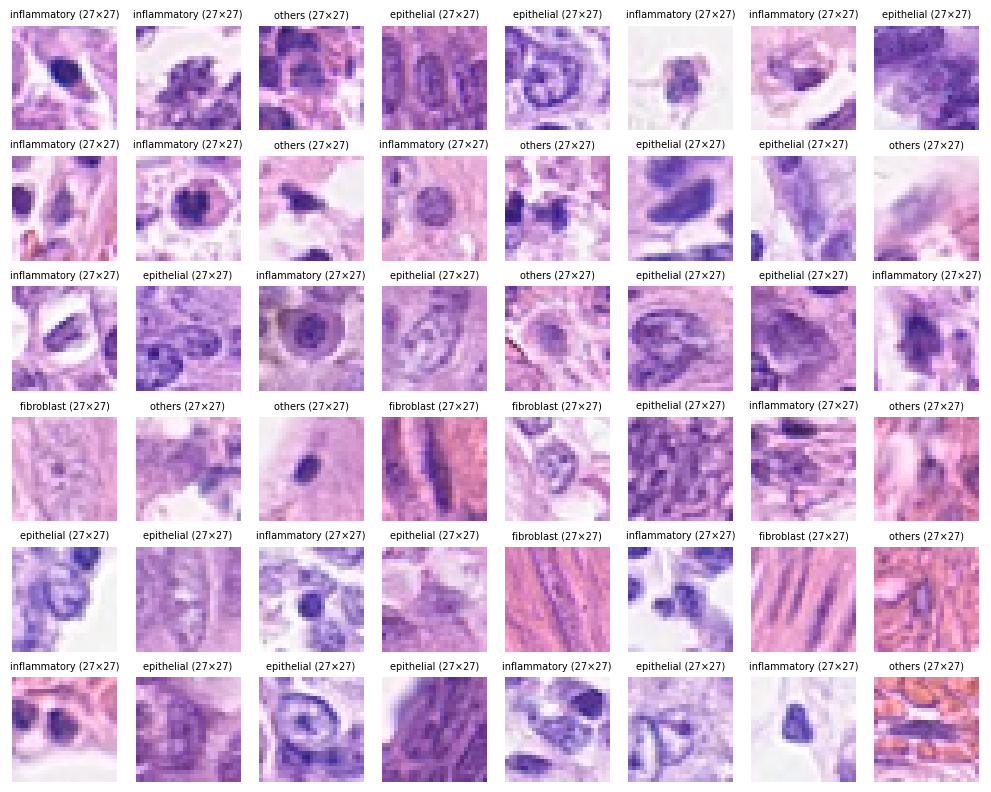

In [21]:
# visualize random set of images with cell type label and image sizes

# randomly select 54 images
sampled_df = labels_main.sample(n=54, random_state=42).reset_index(drop=True)

image_dir = Path('data/patch_images')

# plot
rows = 6
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(10, 8)) 
for ax, (_, row) in zip(axes.flatten(), sampled_df.iterrows()):
    img_path = image_dir / row['ImageName']
    
    img = Image.open(img_path)
    width, height = img.size
    ax.imshow(img)
    ax.set_title(f"{row['cellTypeName']} ({width}×{height})", fontsize=7)
    
    ax.axis('off')

plt.tight_layout()
plt.show()

### Data loading

In [22]:
def set_seed(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

set_seed(seed=42)

In [23]:
class ColonCellDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['imagePath']).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = row['cellType']
        return image, label


In [24]:
# function to calculate mean and standard deviation of train images

def get_mean_std(train_data):
    total_images= 0
    mean = torch.zeros(3)
    std = torch.zeros(3)

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    dataset = ColonCellDataset(train_data, transform=transform)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)


    for images, _ in tqdm(loader,total=len(loader)):

        batch_size, num_channels, height, width = images.shape
        total_images += batch_size

        # Sum mean and std per channel
        mean += images.mean(dim=(0, 2, 3)) * batch_size
        std += images.std(dim=(0, 2, 3)) * batch_size

    mean /= total_images
    std /= total_images

    return mean, std

In [25]:
# calculating mean and standard diviation for train dataset
train_data_mean, train_data_std = get_mean_std(df_train)

print(f"Mean of train dataset : {train_data_mean}")
print(f"Standard deviation of train dataset : {train_data_std}")

100%|██████████| 47/47 [00:00<00:00, 56.94it/s]

Mean of train dataset : tensor([0.7692, 0.5969, 0.8084])
Standard deviation of train dataset : tensor([0.1518, 0.1710, 0.1062])


In [26]:
# base transform for train dataset
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])
# base transform for validation dataset
val_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])

# transform with augmentation for train dataset
train_transform_2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((64,64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())  
])


# transform to 224x224
train_transform_3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())  
])

val_transform_3 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])


train_transform_small = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())  
])
val_transform_small = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])

In [27]:
# base
train_dataset = ColonCellDataset(df_train, transform=train_transform)
val_dataset   = ColonCellDataset(df_val, transform=val_transform)
test_dataset  = ColonCellDataset(df_test, transform=val_transform)

# with transform 2
train_dataset_2 = ColonCellDataset(df_train, transform=train_transform_2)

# for 224 model
train_dataset_224 = ColonCellDataset(df_train, transform=train_transform_3)
val_dataset_224   = ColonCellDataset(df_val, transform=val_transform_3)

#27x27
train_dataset_small = ColonCellDataset(df_train, transform=train_transform_small)
val_dataset_small   = ColonCellDataset(df_val, transform=val_transform_small)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=0)

train_loader_2 = DataLoader(train_dataset_2, batch_size=64, shuffle=True, num_workers=0)

train_loader_small = DataLoader(train_dataset_small, batch_size=64, shuffle=True, num_workers=0)
val_loader_small   = DataLoader(val_dataset_small,   batch_size=64, shuffle=False, num_workers=0)

In [29]:
# loading with weighted random sampler
class_counts = np.bincount(df_train['cellType'])
class_weights = 1. / class_counts
sample_weights = class_weights[df_train['cellType']]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

randomSampler_train_loader = DataLoader(train_dataset_2, batch_size=64, sampler=sampler)

# for 224 model with random sampling
train_loader_224 = DataLoader(train_dataset_224, batch_size=64, sampler=sampler)
val_loader_224   = DataLoader(val_dataset_224,   batch_size=64, shuffle=False, num_workers=0)

In [30]:
print(f"No of batches in  base train data loader = {len(train_loader)}")
print(f"No of batches in  base val data loader = {len(val_loader)}")
print(f"No of batches in  base test data loader = {len(test_loader)}\n")
print(f"No of batches in  randomSampler_train_loader = {len(randomSampler_train_loader)}\n")


No of batches in  base train data loader = 93
No of batches in  base val data loader = 33
No of batches in  base test data loader = 30

No of batches in  randomSampler_train_loader = 93



##### Observing class counts in each train loaders

In [31]:
def count_sampled_labels(loader):
    label_counts = Counter()

    for images, labels in loader:
        labels = labels.cpu().numpy()
        label_counts.update(labels)

    return dict(label_counts)

In [32]:
sampled_label_counts = count_sampled_labels(train_loader)
print("Label distribution in base train loader:")
for label, count in sampled_label_counts.items():
    print(f"Class {label}: {count} samples")

sampled_label_counts = count_sampled_labels(randomSampler_train_loader)
print("\nLabel distribution in train loader with sampling:")
for label, count in sampled_label_counts.items():
    print(f"Class {label}: {count} samples")

sampled_label_counts = count_sampled_labels(train_loader_224)
print("\nLabel distribution in train loader for 224 model:")
for label, count in sampled_label_counts.items():
    print(f"Class {label}: {count} samples")

Label distribution in base train loader:
Class 2: 2314 samples
Class 3: 1177 samples
Class 1: 1400 samples
Class 0: 1053 samples

Label distribution in train loader with sampling:
Class 0: 1484 samples
Class 3: 1454 samples
Class 1: 1459 samples
Class 2: 1547 samples

Label distribution in train loader for 224 model:
Class 2: 1504 samples
Class 3: 1525 samples
Class 0: 1430 samples
Class 1: 1485 samples


In [33]:
# observing batch shape and several labels for one batch in train loader
images, labels = next(iter(train_loader))

print(f"Shape of a batch : {images.shape}")  
print(f"Sample labels for first 5 images of that batch : {labels[:5]}")    


Shape of a batch : torch.Size([64, 3, 64, 64])
Sample labels for first 5 images of that batch : tensor([3, 3, 2, 0, 3])


##### Temporary subset

In [34]:
# temporary creating a subset to ensure the pipeline working properly

# from torch.utils.data import Subset

# small_train_dataset = Subset(train_dataset, range(100))
# small_val_dataset = Subset(val_dataset,range(50))

# small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True, num_workers=0)
# small_val_loader = DataLoader(small_val_dataset,batch_size=16,num_workers=0)

## Helper functions

In [35]:
def multiclass_train_model_v1(model, train_data_loader, val_data_loader, loss_function, optimizer, num_classes, epoch_count, early_stop_count, device):

  """
  This function is intended to train and validate the model.
  Consist of both train and validation loops. Include an early stop criteria.
  
  Returns:
      Best model, train losses, train accuracies, validation losses, validation accuracies  
  """

  #setting model to device
  model = model.to(device)

  #tracking metrics and loss history
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  #accuracy metrics
  train_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)
  val_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)

  best_val_loss = float('inf')
  best_model_weights = copy.deepcopy(model.state_dict())
  patience_counter = early_stop_count

  for epoch in tqdm(range(epoch_count), desc="Epochs"):

    #--model training--
    model.train()
    train_accuracy_fn.reset()
    running_train_loss = 0.0

    for images, labels in tqdm(train_data_loader, desc="Training", leave=False):

      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = loss_function(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_train_loss += loss.item()*images.size(0)
      predictions = torch.argmax(outputs, dim=1)
      train_accuracy_fn.update(predictions, labels)

    avg_train_loss = running_train_loss/len(train_data_loader.dataset)
    avg_train_accuracy = train_accuracy_fn.compute().item()

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    #--model validation--
    model.eval()

    val_accuracy_fn.reset()
    running_val_loss = 0.0

    with torch.no_grad():

      for images, labels in tqdm(val_data_loader, desc="Validation", leave=False):

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        running_val_loss += loss.item() * images.size(0)

        predictions = torch.argmax(outputs, dim=1)
        val_accuracy_fn.update(predictions, labels)

      avg_val_loss = running_val_loss/len(val_data_loader.dataset)
      avg_val_accuracy = val_accuracy_fn.compute().item()

      val_losses.append(avg_val_loss)
      val_accuracies.append(avg_val_accuracy)

      #early stop check
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = early_stop_count
      else:
        patience_counter -= 1
        if patience_counter == 0:
          break
  
  #loading the best model weights
  model.load_state_dict(best_model_weights)

  #return predictions and metrics
  return model, train_losses, train_accuracies, val_losses, val_accuracies

In [36]:
def multiclass_train_model_v2(model, train_data_loader, val_data_loader, loss_function, optimizer, scheduler, num_classes, epoch_count, early_stop_count, device):

  """
  This function is intended to train and validate the model.
  Consist of both train and validation loops. Include an early stop criteria.
  
  Returns:
      Best model, train losses, train accuracies, validation losses, validation accuracies  
  """

  #setting model to device
  model = model.to(device)

  #tracking metrics and loss history
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  #accuracy metrics
  train_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)
  val_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)

  best_val_loss = float('inf')
  best_model_weights = copy.deepcopy(model.state_dict())
  patience_counter = early_stop_count

  for epoch in range(epoch_count):

    #--model training--
    model.train()
    train_accuracy_fn.reset()
    running_train_loss = 0.0

    for images, labels in tqdm(train_data_loader, desc="Training", leave=False):

      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = loss_function(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_train_loss += loss.item()*images.size(0)
      predictions = torch.argmax(outputs, dim=1)
      train_accuracy_fn.update(predictions, labels)

    avg_train_loss = running_train_loss/len(train_data_loader.dataset)
    avg_train_accuracy = train_accuracy_fn.compute().item()

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    #--model validation--
    model.eval()

    val_accuracy_fn.reset()
    running_val_loss = 0.0

    with torch.no_grad():

      for images, labels in tqdm(val_data_loader, desc="Validation", leave=False):

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        running_val_loss += loss.item() * images.size(0)

        predictions = torch.argmax(outputs, dim=1)
        val_accuracy_fn.update(predictions, labels)

      avg_val_loss = running_val_loss/len(val_data_loader.dataset)
      avg_val_accuracy = val_accuracy_fn.compute().item()

      val_losses.append(avg_val_loss)
      val_accuracies.append(avg_val_accuracy)

      if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
      else:
        scheduler.step()


      #early stop check
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = early_stop_count
      else:
        patience_counter -= 1
        if patience_counter == 0:
          break
  
  #loading the best model weights
  model.load_state_dict(best_model_weights)

  #return predictions and metrics
  return model, train_losses, train_accuracies, val_losses, val_accuracies

In [37]:
def evaluate_model_predictions(model, val_data_loader, device):

    """
    This function is defined to make the predictions from a given model. 
    Main usage is to make predictions, to be used in evaluation metrics.

    Returns :
        Predictions, Targets
    """

    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc="Evaluation", leave=False):

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.append(predictions.cpu())
            all_targets.append(labels.cpu())
        
        all_predictions = torch.cat(all_predictions)
        all_targets = torch.cat(all_targets)

    return all_predictions, all_targets

In [38]:
def plot_loss_and_accuracy_cellTypeClassification(train_losses, train_accuracies, val_losses, val_accuracies):

    """ 
    This function is used to plot train and validation loss and accuracy curves for cell type classification.
    """

    plt.figure(figsize=(15, 5))
  
    plt.subplot(1,2,1)
    plt.plot(train_losses,label="Train loss")
    plt.plot(val_losses,label="Validation loss")
    plt.xlabel("No of epoches")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.grid(axis='x')
    plt.legend()
    # plt.gca().xaxis.set_major_locator(MultipleLocator(1)) 

    plt.subplot(1,2,2)
    plt.plot(train_accuracies,label="Train accuracy")
    plt.plot(val_accuracies,label="Validation accuracy")
    plt.xlabel("No of epoches")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.grid(axis='x')
    plt.legend()
    # plt.gca().xaxis.set_major_locator(MultipleLocator(1))

    plt.tight_layout()
    plt.show()

In [39]:
def plot_confusion_metrics_cellTypeClassification(predictions, targets):

  """ 
  This function is defined to plot the confusion metrics for cell type classification.
  """

  cm_metric = MulticlassConfusionMatrix(num_classes=4)
  cm = cm_metric(predictions,targets)
  cm = cm.numpy()

  #plot
  plt.figure(figsize=(8, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
              xticklabels=["fibroblast", "inflammatory","epithelial","others"], 
              yticklabels=["fibroblast", "inflammatory","epithelial","others"])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [40]:
def evaluate_per_class_metrics_cellTypeClassification(predictions, targets):

    """ 
    This function is defined to generate the classification report for cell type classification.
    """

    class_names = ["fibroblast", "inflammatory","epithelial","others"]
    print("Classification Report:\n")
    report = classification_report(y_true=targets, y_pred=predictions, target_names=class_names, digits=3)
    print(report)

In [41]:
def calculate_macro_accuracy(predictions, targets):

    """This function is defined to calculate the macro accuracy for classification."""

    cm = confusion_matrix(y_true=targets, y_pred=predictions)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    macro_acc = np.mean(per_class_accuracy)
    print(f"Macro Accuracy: {macro_acc:.4f}")


In [42]:
def generate_evaluation_metrics(train_losses, train_accuracies, val_losses, val_accuracies, predictions, targets):

    """ 
    This generates/calculate evaluation metrics/plots.
    """

    plot_loss_and_accuracy_cellTypeClassification(train_losses=train_losses,train_accuracies=train_accuracies,
                                                  val_losses=val_losses, val_accuracies=val_accuracies)
    
    plot_confusion_metrics_cellTypeClassification(predictions=predictions, targets=targets)

    evaluate_per_class_metrics_cellTypeClassification(predictions=predictions, targets=targets)

    calculate_macro_accuracy(predictions=predictions, targets=targets)

## Models

In [43]:
class CellTypeClassification_CNNModel_V0(nn.Module):

  def __init__(self):
    super().__init__()

    # Convolutional Block 1
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)    
    )

    # Convolutional Block 2
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Convolutional Block 3
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


    # Fully connected layers
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=128*8*8,
                  out_features=4)
    )

  def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block3(self.conv_block2(self.conv_block1(x)))) 

In [44]:
class CellTypeClassification_CNNModel_V1(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),  # Regularization
            nn.Linear(in_features=128 * 8 * 8, out_features=4)  # Adjust 8x8 based on input image size
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x


In [45]:
# this model expects 224x224

class CellTypeClassification_CNNModel_V224(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=16,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*3*3,
                  out_features=4)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

In [46]:
class CellTypeClassification_CNNModel_Small(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional Block 1: 27x27 → 13x13
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # → [B, 32, 27, 27]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                                  # → [B, 32, 13, 13]
        )

        # Convolutional Block 2: 13x13 → 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # → [B, 64, 13, 13]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                                   # → [B, 64, 6, 6]
        )

        # Convolutional Block 3: 6x6 → 3x3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # → [B, 128, 6, 6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                                   # → [B, 128, 3, 3]
        )

        # Fully Connected
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 3 * 3, out_features=4)  # Adjust to your number of classes
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

In [47]:
class CellTypeClassification_CNNModel_Improved(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # Convolutional Block 1: [3, 64, 64] → [32, 32, 32]
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 2: [32, 32, 32] → [64, 16, 16]
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 3: [64, 16, 16] → [128, 8, 8]
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 4: [128, 8, 8] → [256, 4, 4]
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),                      # [256, 4, 4] → 256*4*4 = 4096
            nn.Linear(256 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.classifier(x)
        return x

## Training and validating models

##### Base model

Epochs: 100%|██████████| 100/100 [04:51<00:00,  2.91s/it]


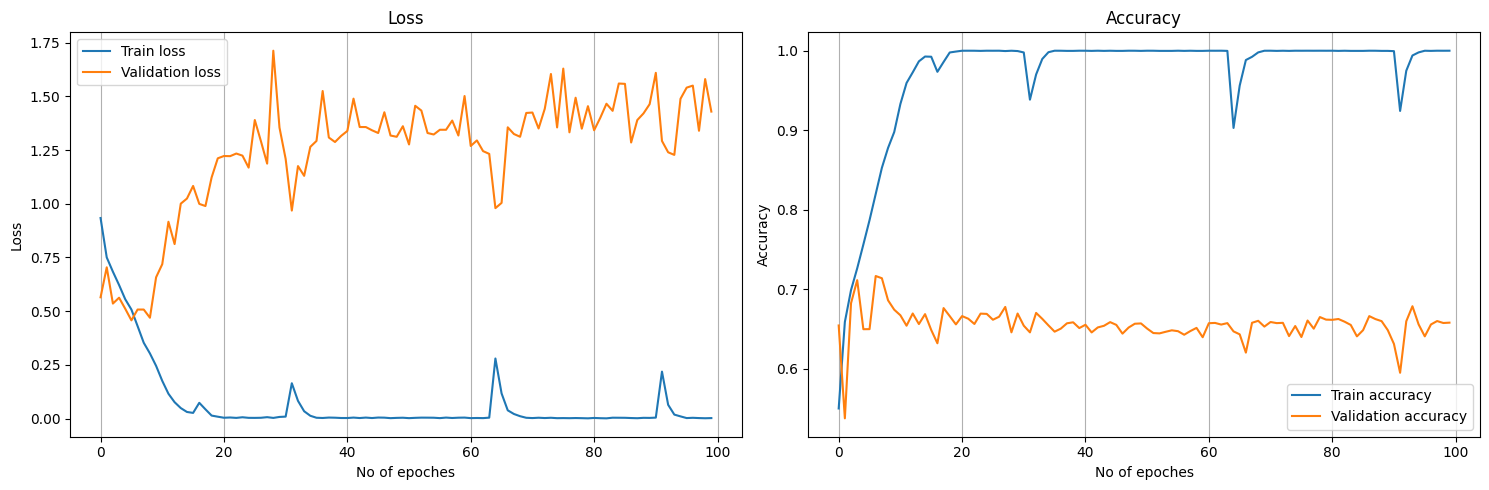

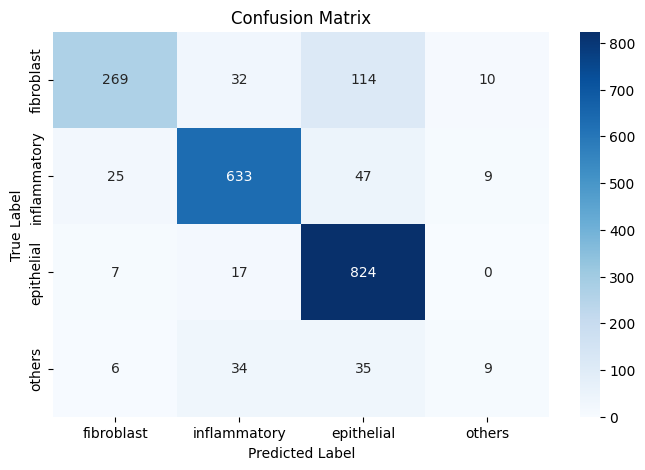

Classification Report:

              precision    recall  f1-score   support

  fibroblast      0.876     0.633     0.735       425
inflammatory      0.884     0.887     0.885       714
  epithelial      0.808     0.972     0.882       848
      others      0.321     0.107     0.161        84

    accuracy                          0.838      2071
   macro avg      0.722     0.650     0.666      2071
weighted avg      0.828     0.838     0.824      2071

Macro Accuracy: 0.6496


In [48]:
#instantiating a model
model = CellTypeClassification_CNNModel_V0()

#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
    model=model,
    train_data_loader=train_loader,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=100,
    early_stop_count=100,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=model, val_data_loader=val_loader, device=device)

# generating metrics
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)


##### Base model with data augmented transformations

Epochs: 100%|██████████| 100/100 [05:49<00:00,  3.50s/it]


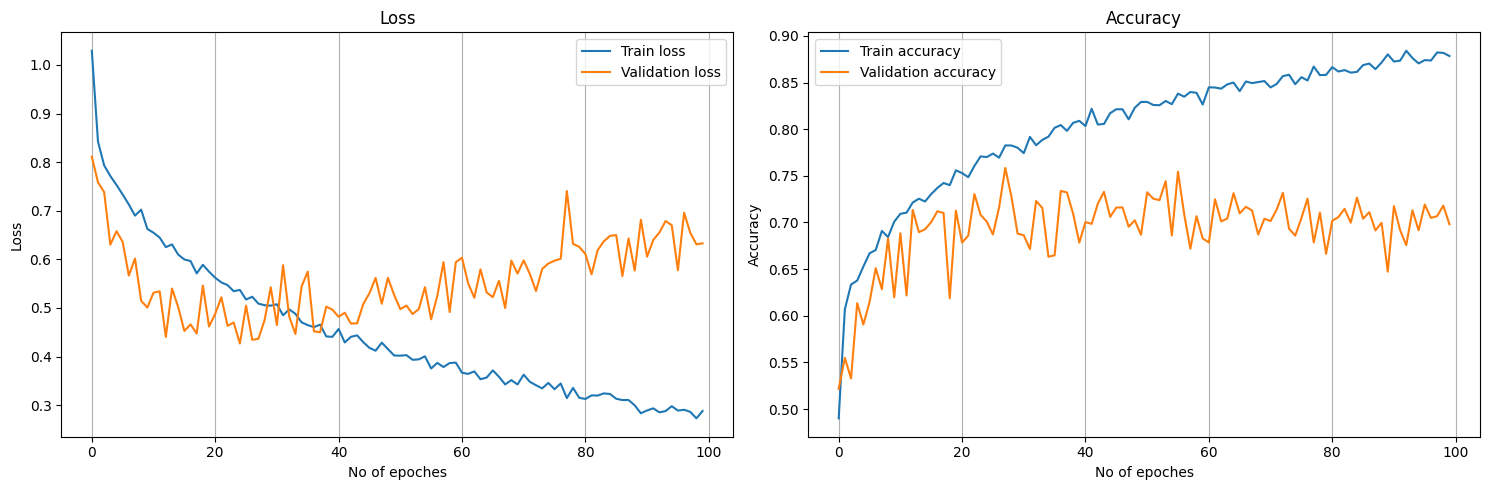

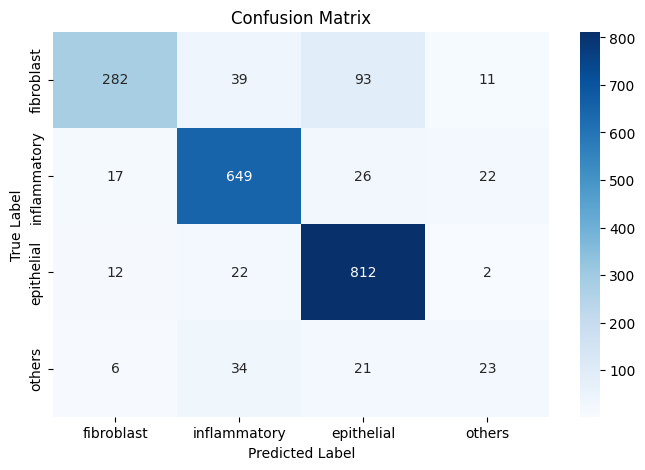

Classification Report:

              precision    recall  f1-score   support

  fibroblast      0.890     0.664     0.760       425
inflammatory      0.872     0.909     0.890       714
  epithelial      0.853     0.958     0.902       848
      others      0.397     0.274     0.324        84

    accuracy                          0.853      2071
   macro avg      0.753     0.701     0.719      2071
weighted avg      0.849     0.853     0.845      2071

Macro Accuracy: 0.7010


In [49]:
#instantiating a model
model = CellTypeClassification_CNNModel_V0()

#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
    model=model,
    train_data_loader=train_loader_2,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=100,
    early_stop_count=100,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

# generating metrics
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

##### Base model with random weighted sampling

Epochs: 100%|██████████| 100/100 [05:37<00:00,  3.37s/it]


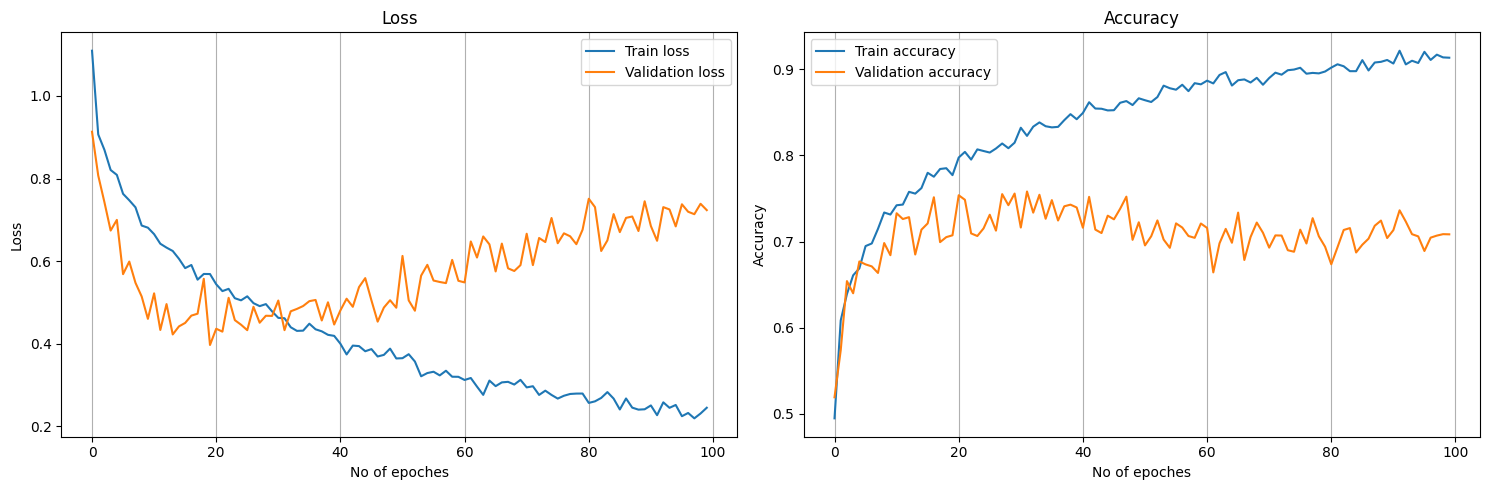

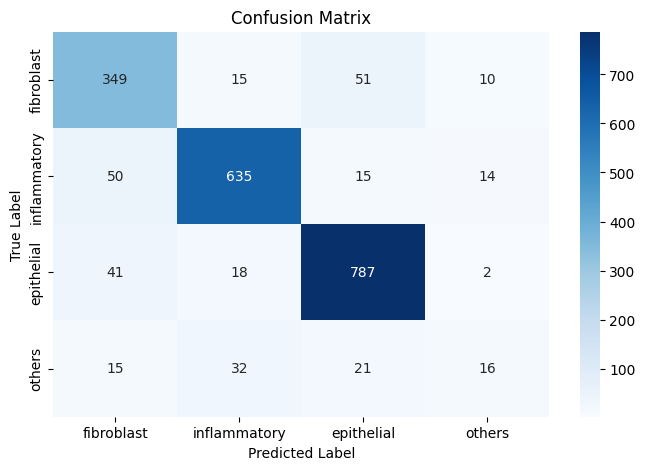

Classification Report:

              precision    recall  f1-score   support

  fibroblast      0.767     0.821     0.793       425
inflammatory      0.907     0.889     0.898       714
  epithelial      0.900     0.928     0.914       848
      others      0.381     0.190     0.254        84

    accuracy                          0.863      2071
   macro avg      0.739     0.707     0.715      2071
weighted avg      0.854     0.863     0.857      2071

Macro Accuracy: 0.7073


In [50]:
#instantiating a model
model = CellTypeClassification_CNNModel_V0()

#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
    model=model,
    train_data_loader=randomSampler_train_loader,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=100,
    early_stop_count=100,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

# generating metrics
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

##### Base model with dropout

Epochs: 100%|██████████| 100/100 [06:13<00:00,  3.73s/it]


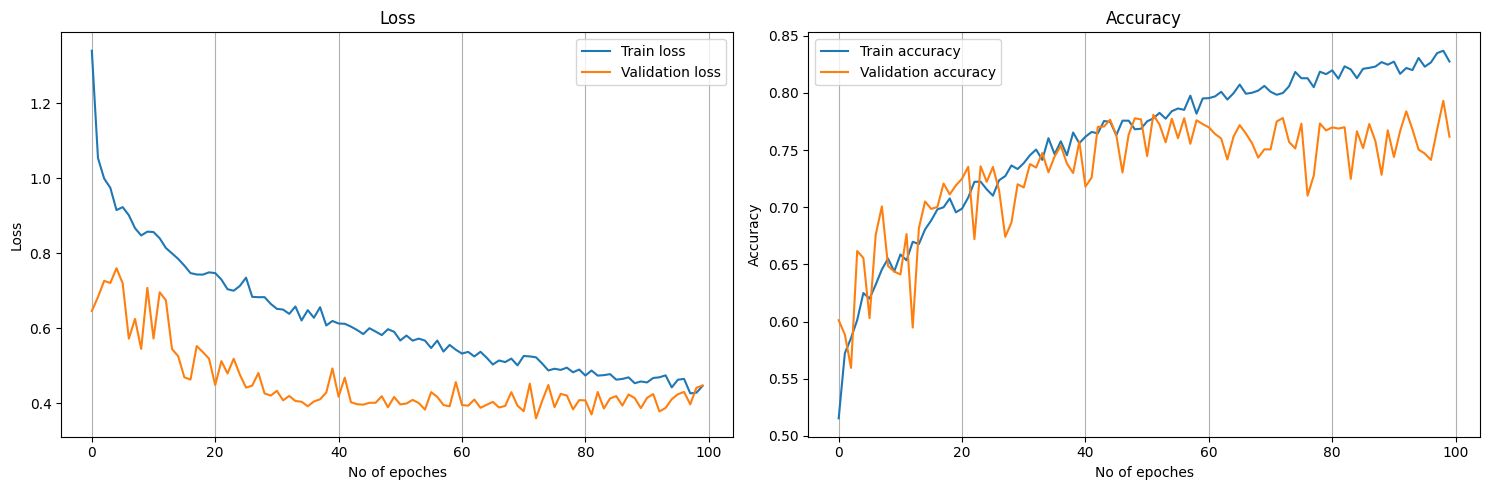

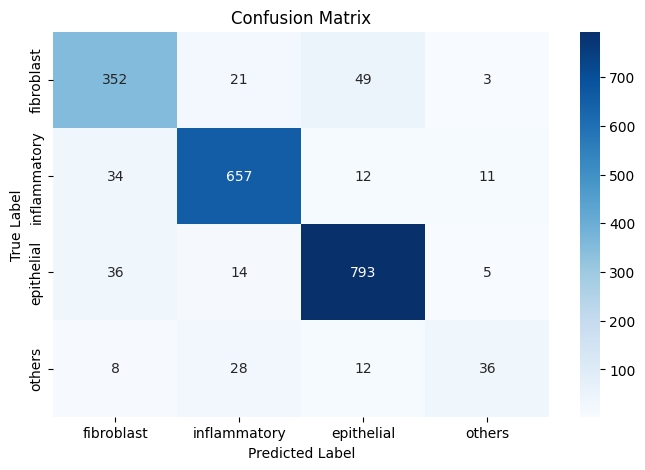

Classification Report:

              precision    recall  f1-score   support

  fibroblast      0.819     0.828     0.823       425
inflammatory      0.912     0.920     0.916       714
  epithelial      0.916     0.935     0.925       848
      others      0.655     0.429     0.518        84

    accuracy                          0.887      2071
   macro avg      0.825     0.778     0.796      2071
weighted avg      0.884     0.887     0.885      2071

Macro Accuracy: 0.7780


In [51]:
#instantiating a model
model = CellTypeClassification_CNNModel_V1()

#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
    model=model,
    train_data_loader=randomSampler_train_loader,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=100,
    early_stop_count=100,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

# generating metrics
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

##### Base model hyperparameter tuning


Training with batch size = 32, learning rate = 0.0001


Epochs: 100%|██████████| 400/400 [1:59:34<00:00, 17.94s/it]    


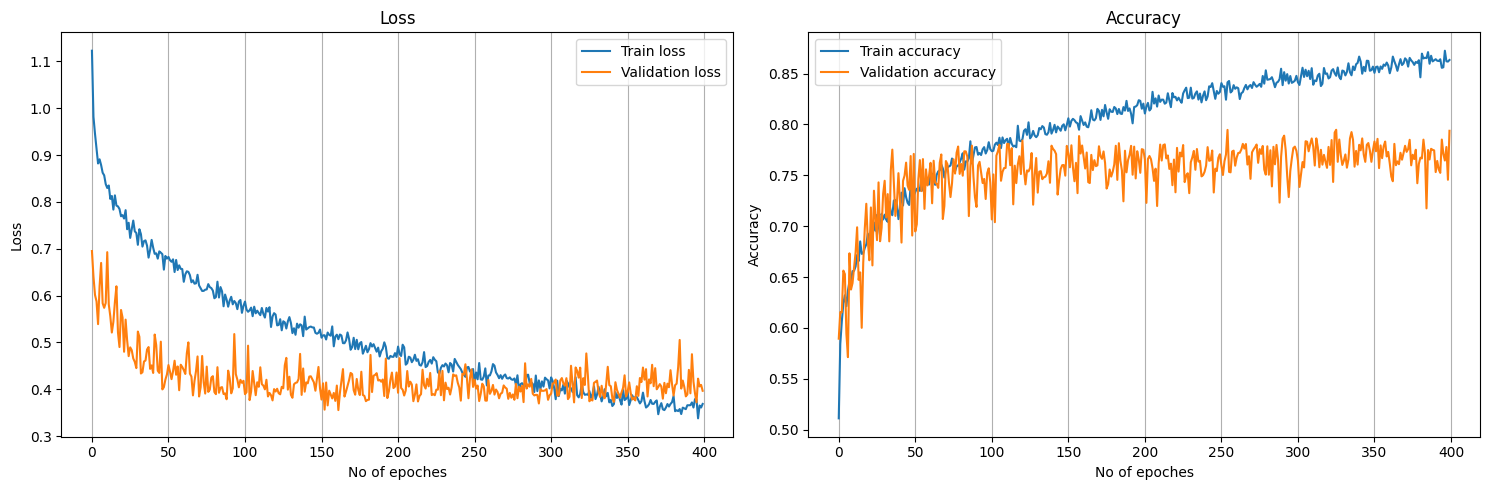

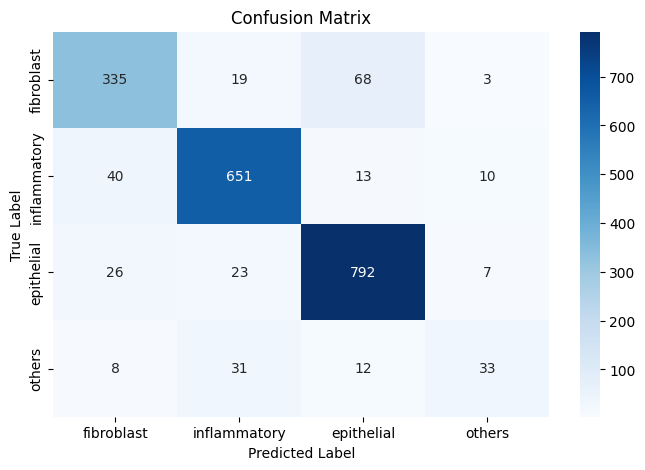

Classification Report:

              precision    recall  f1-score   support

  fibroblast      0.819     0.788     0.803       425
inflammatory      0.899     0.912     0.905       714
  epithelial      0.895     0.934     0.914       848
      others      0.623     0.393     0.482        84

    accuracy                          0.874      2071
   macro avg      0.809     0.757     0.776      2071
weighted avg      0.870     0.874     0.871      2071

Macro Accuracy: 0.7567

Training with batch size = 32, learning rate = 0.0005


Epochs:  62%|██████▏   | 249/400 [1:35:04<12:08,  4.83s/it]    

In [ ]:
#parameter grid
learning_rates = [0.0001,0.0005, 0.001]
batch_sizes = [32,64,128]

for batch_size in batch_sizes:

    train_loader = DataLoader(train_dataset_2, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    for lr in learning_rates:

        print(f"\nTraining with batch size = {batch_size}, learning rate = {lr}")

        #instantiating a model
        model = CellTypeClassification_CNNModel_V1()

        #defining loss function and  optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

        #model training
        best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
            model=model,
            train_data_loader=train_loader,
            val_data_loader=val_loader,
            loss_function=loss_fn,
            optimizer=optimizer,
            num_classes=4,
            epoch_count=400,
            early_stop_count=400,
            device=device
        )

        #making predictions for val data with best model
        val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

        generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

##### Improved model with more epochs

In [ ]:
train_loader = DataLoader(train_dataset_2, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset,   batch_size=64, shuffle=False)

#instantiating a model
model = CellTypeClassification_CNNModel_Improved()

#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
    model=model,
    train_data_loader=train_loader,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=200,
    early_stop_count=200,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

##### Improved model hyperparameter tuning

In [ ]:
#parameter grid
learning_rates = [0.0001,0.001]
batch_sizes = [32,64,128]
weight_decays = [0,0.001]

for batch_size in batch_sizes:

    train_loader = DataLoader(train_dataset_2, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    for lr in learning_rates:
        for weight_decay in weight_decays:

            print(f"\nTraining with batch size = {batch_size}, learning rate = {lr}, weight_decay = {weight_decay}")

            #instantiating a model
            model = CellTypeClassification_CNNModel_Improved()

            #defining loss function and  optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            
            #model training
            best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
                model=model,
                train_data_loader=train_loader,
                val_data_loader=val_loader,
                loss_function=loss_fn,
                optimizer=optimizer,
                num_classes=4,
                epoch_count=50,
                early_stop_count=10,
                device=device
            )

            #making predictions for val data with best model
            val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

            generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                                val_losses=val_losses, val_accuracies=val_accuracies,
                                predictions=val_predictions, targets=val_targets)

##### Small 27x27 model

In [ ]:
#instantiating a model
model_0 = CellTypeClassification_CNNModel_Small()

#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v0(
    model=model_0,
    train_data_loader=train_loader_small,
    val_data_loader=val_loader_small,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=50,
    early_stop_count=10,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader_small, device=device)

In [ ]:
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

##### Weight decay and scheduler

In [ ]:
def multiclass_train_model_v1(model, train_data_loader, val_data_loader, loss_function, optimizer, scheduler, num_classes, epoch_count, early_stop_count, device):

  """
  This function is intended to train and validate the model.
  Consist of both train and validation loops. Include an early stop criteria.

  In addition to v0, this contain the learning rate scheduler.
  
  Returns:
      Best model, train losses, train accuracies, validation losses, validation accuracies  
  """

  #setting model to device
  model = model.to(device)

  #tracking metrics and loss history
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  #accuracy metrics
  train_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)
  val_accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes, average='macro').to(device)

  best_val_loss = float('inf')
  best_model_weights = copy.deepcopy(model.state_dict())
  patience_counter = early_stop_count

  for epoch in range(epoch_count):

    print("-"*100)
    print(f"Epoch {epoch+1}/{epoch_count}")

    #--model training--
    model.train()
    train_accuracy_fn.reset()
    running_train_loss = 0.0

    for images, labels in tqdm(train_data_loader, desc="Training", leave=False):

      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = loss_function(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_train_loss += loss.item()*images.size(0)
      predictions = torch.argmax(outputs, dim=1)
      train_accuracy_fn.update(predictions, labels)

    avg_train_loss = running_train_loss/len(train_data_loader.dataset)
    avg_train_accuracy = train_accuracy_fn.compute().item()

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    #--model validation--
    model.eval()

    val_accuracy_fn.reset()
    running_val_loss = 0.0

    with torch.no_grad():

      for images, labels in tqdm(val_data_loader, desc="Validation", leave=False):

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)

        running_val_loss += loss.item() * images.size(0)

        predictions = torch.argmax(outputs, dim=1)
        val_accuracy_fn.update(predictions, labels)

      avg_val_loss = running_val_loss/len(val_data_loader.dataset)
      avg_val_accuracy = val_accuracy_fn.compute().item()

      val_losses.append(avg_val_loss)
      val_accuracies.append(avg_val_accuracy)

      scheduler.step(avg_val_loss)

      print(f"Train loss : {avg_train_loss:.4f} \t| Train accuracy {avg_train_accuracy:.4f}")
      print(f"Val loss : {avg_val_loss:.4f} \t| Val accuracy {avg_val_accuracy:.4f}\n")
      print(f"Epoch {epoch+1} | Val loss: {avg_val_loss:.4f} | Best so far: {best_val_loss:.4f} | Patience left: {patience_counter}")
      
      #early stop check
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = early_stop_count
      else:
        patience_counter -= 1
        if patience_counter == 0:
          print("Early stopping triggered..")
          break
  
  #loading the best model weights
  model.load_state_dict(best_model_weights)

  #return predictions and metrics
  return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
#instantiating a model
model_2 = CellTypeClassification_CNNModel_V0()

#defining loss function sheduler and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_2.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v1(
    model=model_2,
    train_data_loader=train_loader_2,
    val_data_loader=val_loader,
    loss_function=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    num_classes=4,
    epoch_count=30,
    early_stop_count=10,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader, device=device)

In [ ]:
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

##### Resizing and a different model

### Transfer learning models

In [ ]:
from torchvision import datasets, models

In [ ]:
weights = models.ResNet18_Weights.DEFAULT

transform_en = weights.transforms()

In [ ]:
train_dataset_en = ColonCellDataset(df_train, transform=transform_en)
val_dataset_en   = ColonCellDataset(df_val, transform=transform_en)

train_loader_en = DataLoader(train_dataset_en, batch_size=128, sampler=sampler)
val_loader_en   = DataLoader(val_dataset_en,   batch_size=128, shuffle=False, num_workers=0)

In [ ]:
model = models.resnet18(weights=weights).to(device)

In [ ]:
for params in model.parameters():
  params.requires_grad = False

#updating the classifer
torch.manual_seed(42)
output_shape = 4
model.fc = nn.Linear(in_features=model.fc.in_features,
                     out_features=output_shape).to(device)

In [ ]:
#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v0(
    model=model,
    train_data_loader=train_loader_en,
    val_data_loader=val_loader_en,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=50,
    early_stop_count=10,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader_en, device=device)

In [ ]:
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)

In [ ]:
train_loader_en = DataLoader(train_dataset_en, batch_size=128, shuffle=True, num_workers=0)
val_loader_en   = DataLoader(val_dataset_en,   batch_size=128, shuffle=False, num_workers=0)

In [ ]:
model = models.resnet18(weights=weights).to(device)

In [ ]:
for params in model.parameters():
  params.requires_grad = False

#updating the classifer
torch.manual_seed(42)
output_shape = 4
model.fc = nn.Linear(in_features=model.fc.in_features,
                     out_features=output_shape).to(device)

In [ ]:
#defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#model training
best_model, train_losses, train_accuracies, val_losses, val_accuracies = multiclass_train_model_v0(
    model=model,
    train_data_loader=train_loader_en,
    val_data_loader=val_loader_en,
    loss_function=loss_fn,
    optimizer=optimizer,
    num_classes=4,
    epoch_count=50,
    early_stop_count=10,
    device=device
)

#making predictions for val data with best model
val_predictions, val_targets = evaluate_model_predictions(model=best_model, val_data_loader=val_loader_en, device=device)

In [ ]:
generate_evaluation_metrics(train_losses=train_losses, train_accuracies=train_accuracies,
                            val_losses=val_losses, val_accuracies=val_accuracies,
                            predictions=val_predictions, targets=val_targets)